In [1]:

import os
import sys

cwd0 = './config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color
vID.init(cwd0)
import tools4PytChem as t4p

**Start at:** Friday 10 November 2023, 10:24:43  
**Hostname:** localhost.localdomain (Linux)

<p style="text-align: center"><img width="800px" src="./config/svg/PytChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>

# <!-- TITLE --> MOLECULAR DYNAMICS - VELOCITY VERLET ALGORITHM

## Introduction

<div class="intro">

This computer lab deal with Classical molecular dynamics. In the context of theoretical chemistry, classical molecular dynamic is a computational method that allows study the motion of atoms or molecule under the influence of a specific potential. The principle of molecular dynamic is to solve Newton’s equations of motions in order to simulate the dynamical behaviour of nuclei.
    
The principle of classical molecular dynamics is to solve Newton's equations to model the dynamic behavior of nuclei. In order to calculate the positions of atoms at a given time, it is necessary to use a "propagator". Of the many propagators available, the "Velocity-Verlet" type is among the most widely used. In this case, positions and velocities are propagated over time according to the following equations.
\begin{align}    
\mathbf{x(t+\delta t)=x(t)+v_x(t).\delta t+\frac{1}{2} \gamma(t).\delta t^2} \\    
\end{align}
    
\begin{align}   
\mathbf{v_x(t+\delta t)=v_x(t)+\frac{\gamma(t)+\gamma(t+δt)}{2}.\delta t} \\
\end{align}
    
whith $v(t)$, the velocity (first derivatives of positions with respect to time) and $\gamma (t)$, the acceleration (second derivatives of positions with respect to time).
    
To determine accelerations, we use Newton's law, which relates acceleration to force and thus to the energy gradient.
    
\begin{align}
\vec{\gamma}(t) & = \frac{\vec{F}(t)}{M} \\
\end{align}
    
    
\begin{align}
\vec{F}(t)&=-\vec{\nabla}_x{\mathbf{V(x(t))}}&= -\frac{\partial V(x(t))}{\partial x} \\
\end{align}
    
Initial conditions ($x(t=0)$ and $v(t=0)$) and a potential function are therefore required to achieve dynamics. The propagation of positions and velocities is iterative. By rewriting the "velocity verlet" equations considering t=0, the positions and velocities calculated for δt will become the positions and velocities at t=0 for the next point and so on....
For this project, we'll consider a particle of mass 1 moving on a one-dimensional model potential (the generalisation to two- or more-dimension is straitforward)

</div>



## Definition of the differents potentials

<div class="rqT" title="Directives">
    
- It is necessary to define model potentials before performing MD simulations
- These potentials and the associated forces must be defined using symbolic algebra and may need the SymPy module
</div>


<u>One-dimensional model potentials considered</u>:
    
    
**Harmonic potential**: $$ V(x)=k.(x-x_e)^2 $$


**Morse Potential**: $$V(x)=D_e.(1-e^{-\alpha(x-x_e)})^2$$


**Double_well potential**: $$ V(x)=\frac{1}{2}(f_1(x)+f_2(x))-\frac{1}{2}\sqrt{(f_1(x)-f_2(x))^2+h^2} $$

with $$ f_i(x)=k_i.(x-x_{ei})^2 + V_i $$

    



In [2]:
import sympy as sym
import math
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import random
sym.init_printing()

<div class="rqT" title="Directives">
    
- Each potential can be characterized by several parameters, which need to be defined beforehand. 
</div>

In [3]:
#Define parameters for potentials:
m = 1       # mass of the particle
xe_1 = 0    # Equilibrium distance for harmonic, Morse and double well potentials
xe_2 = -2   # Equilibrium distance for double well potential only

k_1 =  2    # Force constant for harmonic and double well potentials
k_2 =  2    # Force constant for double well potential only

alpha = 0.05     # Parameter for Morse potential
De = 2           # Prefactor for Morse potential

V_1 =  0      # Translation of potential (1) for double well potential
V_2 =  0      # Translation of potential (2) for double well potential

h = 2         # Coupling term for double well potential

<div class="exE">

- To simplify the switch between potentials, define three differents function as a function of x, one for each potential
- <b/>Forces</b> are a point of utmost importance of the algorithm. Define a function to calculate forces for a selected potential
- Display the analytic expression of the selected potential and associated forces
- Plot the selected potential as a function of the variable 'x' (You may need to use the lambdify function in the SymPy module to calculate a numerical value). 
    
</div>

In [4]:
# Define the symbolic variable x for SymPy
x = sym.symbols('x')

# For Different Potentials
# function for calculating harmonic potential
def harmonic_potential(x):
    return k_1 * (x - xe_1)**2

# function for calculating morse potential
def morse_potential(x):
    return De * (1 - sym.exp(-alpha * (x - xe_1)))**2

# function for calculating double well potential
def double_well_potential(x):
    f1 = k_1 * (x - xe_1)**2 + V_1
    f2 = k_2 * (x - xe_2)**2 + V_2
    return (0.5 * (f1 + f2)) - (0.5 * (sym.sqrt(((f1 - f2)**2) + (h**2))))


# For Forces of each Potentials
# function for calculating harmonic force
def harmonic_force(x):
    return -sym.diff(harmonic_potential(x), x)

# function for calculating morse force
def morse_force(x):
    return -sym.diff(morse_potential(x), x)

# function for calculating double well force
def double_well_force(x):
    return -sym.diff(double_well_potential(x), x)

def display(potential, force):
    print("Display the analytic expression of the selected potential:")
    sym.pprint(potential(x), use_unicode=True)
    print("Display the analytic expression of the associated forces:")
    sym.pprint(force(x), use_unicode=True)

In [5]:
# The selected potential is double-well potential
selected_potential = double_well_potential

selected_force = double_well_force

display(selected_potential, selected_force)

Display the analytic expression of the selected potential:
                                __________________________
                               ╱                    2     
     2              2         ╱  ⎛   2            2⎞      
1.0⋅x  + 1.0⋅(x + 2)  - 0.5⋅╲╱   ⎝2⋅x  - 2⋅(x + 2) ⎠  + 4 
Display the analytic expression of the associated forces:
              ⎛      2             2⎞        
          0.5⋅⎝- 16⋅x  + 16⋅(x + 2) ⎠        
-4.0⋅x + ────────────────────────────── - 4.0
             __________________________      
            ╱                    2           
           ╱  ⎛   2            2⎞            
         ╲╱   ⎝2⋅x  - 2⋅(x + 2) ⎠  + 4       


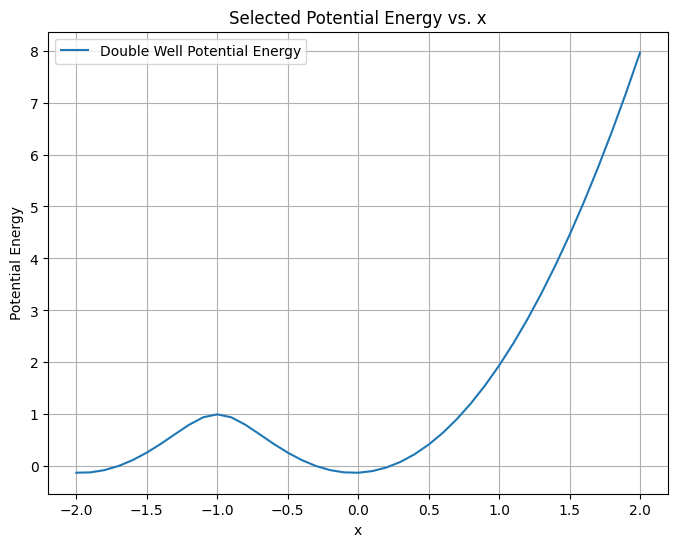

In [6]:
# Plot the selected potential
force_numeric = sym.lambdify(x, selected_potential(x), 'numpy')

x_values = [i/10 for i in range(-20, 21)]
potential_values = [float(force_numeric(val)) for val in x_values]

plt.figure(figsize=(8, 6))
plt.plot(x_values, potential_values, label="Double Well Potential Energy")
plt.xlabel("x")
plt.ylabel("Potential Energy")
plt.title("Selected Potential Energy vs. x")
plt.legend()
plt.grid(True)
plt.show()

## Velocity Verlet Algorithm

<div class="rqT" title="Directives">
    
- Several parameters must be defined to control the MD simulation:
    - step time <b/> δt</b>     
    - Total time or number of steps 
    - The initial position and initial velocity
- <b/>Total energy</b>, defined in the context of Hamiltonian mechanics, is a constant. It must be calculated for each time step in order to check that the algorithm behaves correctly. 
- You will need to use the lambdify function in the SymPy module to calculate a numerical force value for each position.  

</div>

<div class="exE">

- Define the variables that describe the parameters of the MD simulation (initial time will be set to 0)
- Use a loop to implement the velocity verlet algorithm
    - Defining functions for updating positions and speeds can be useful but is not mandatory
- For each step (including the initial step), record in separate tables (or in a single file)
    - Time
    - Position
    - Velocity
    - Energy (i.e value of the potential)
    - Total energy
    
    
</div>

In [7]:
# Define parameters for the MD simulation
delta_t = 0.01      # Step time
total_time = 10.0   # Total simulation time
num_steps = int(total_time / delta_t)  # Number of steps

# Initial conditions
initial_position = 0.0
initial_velocity = 1.0

# Define the symbolic variable x for SymPy
x = sym.symbols('x')

# Define the potential energy functions and forces
# You can choose the potential you want to use here
potential_energy = double_well_potential(x)  # Change to the selected potential
force = double_well_force(x)                # Change to the selected force

# Lambdify the force for numerical calculations
force_numeric = sym.lambdify(x, force, 'numpy')

# Initialize arrays to record data
time_values = []
position_values = []
velocity_values = []
potential_energy_values = []
total_energy_values = []

# Initialize variables
current_time = 0.0
current_position = initial_position
current_velocity = initial_velocity

# Velocity Verlet loop
for step in range(num_steps):
    # Record data at each step
    time_values.append(current_time)
    position_values.append(current_position)
    velocity_values.append(current_velocity)
    potential_energy_values.append(float(potential_energy.subs(x, current_position)))
    
    # Calculate total energy (constant in Hamiltonian mechanics)
    total_energy = float(potential_energy.subs(x, current_position) + 0.5 * m * current_velocity**2)
    total_energy_values.append(total_energy)

    # Update positions and velocities using Velocity Verlet algorithm
    half_step_velocity = current_velocity + 0.5 * (delta_t / m) * force_numeric(current_position)
    current_position = current_position + delta_t * half_step_velocity
    current_velocity = half_step_velocity + 0.5 * (delta_t / m) * force_numeric(current_position)

    # Update time
    current_time += delta_t


In [8]:
# Define the data to be saved
data = {
    "Time": time_values,
    "Position": position_values,
    "Velocity": velocity_values,
    "Potential Energy": potential_energy_values,
    "Total Energy": total_energy_values
}

# Specify the filename
csv_filename = 'md_simulation_data.csv'

df = pd.DataFrame(data)
df.to_csv(csv_filename, index=False, header=True)

print(f"Data saved to {csv_filename}")

Data saved to md_simulation_data.csv


## Post processing

<div class="rqT" title="Directives">
    
- The advantage of MD simulation is that several parameters are stored (in tables or files) and can be used for post-processing
    
    - To check the validity of the algorithm
    - To calculate mean structural or spectroscopic properties

</div>

<div class="exE">

- To check the validity of the algorithm
    - Plot the stored potentials as a function of stored positions 
    - Plot the stored positions or velocities as a function of time
    - Plot the variation in total energy (as a percentage) as a function of time
- To calculate mean structural or spectroscopic properties
    - Calculate the mean value of the position
    
    
</div>

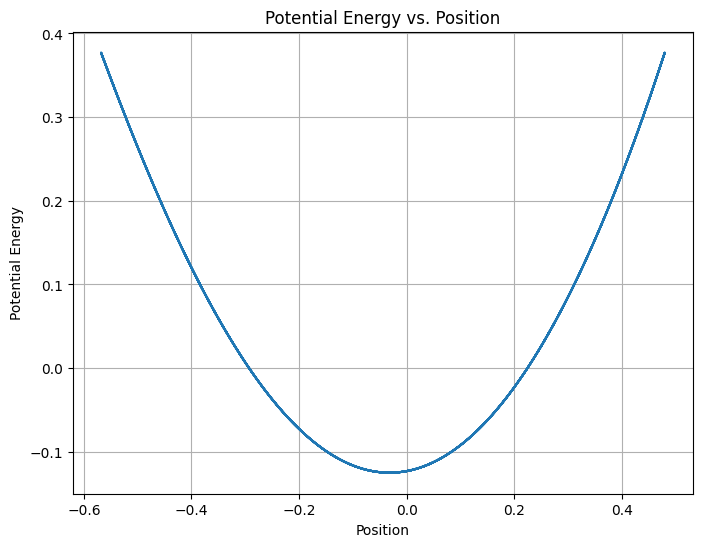

In [9]:
# Plotting stored potentials as a function of stored positions
data = pd.read_csv('md_simulation_data.csv')

positions = data['Position']
potential_energy = data['Potential Energy']

plt.figure(figsize=(8, 6))
plt.plot(positions, potential_energy)
plt.xlabel("Position")
plt.ylabel("Potential Energy")
plt.title("Potential Energy vs. Position")
plt.grid(True)
plt.show()


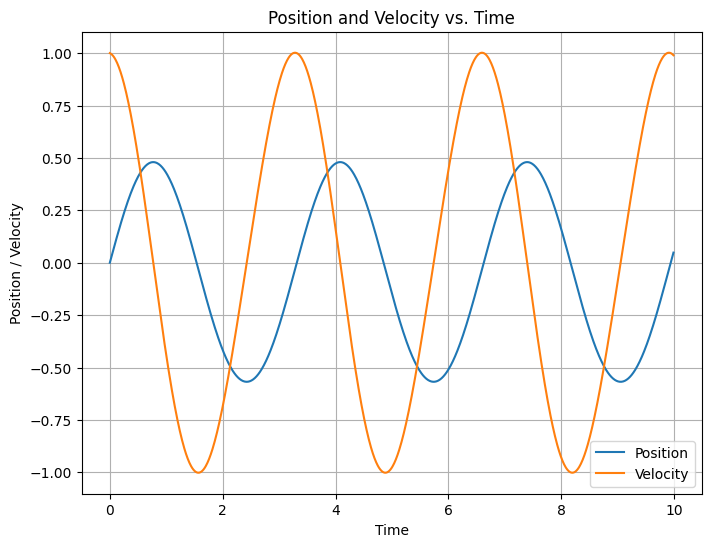

In [10]:
# Plotting the stored positions or velocities as a function of time
time = data['Time']
positions = data['Position']
velocities = data['Velocity']

plt.figure(figsize=(8, 6))
plt.plot(time, positions, label="Position")
plt.plot(time, velocities, label="Velocity")
plt.xlabel("Time")
plt.ylabel("Position / Velocity")
plt.title("Position and Velocity vs. Time")
plt.legend()
plt.grid(True)
plt.show()

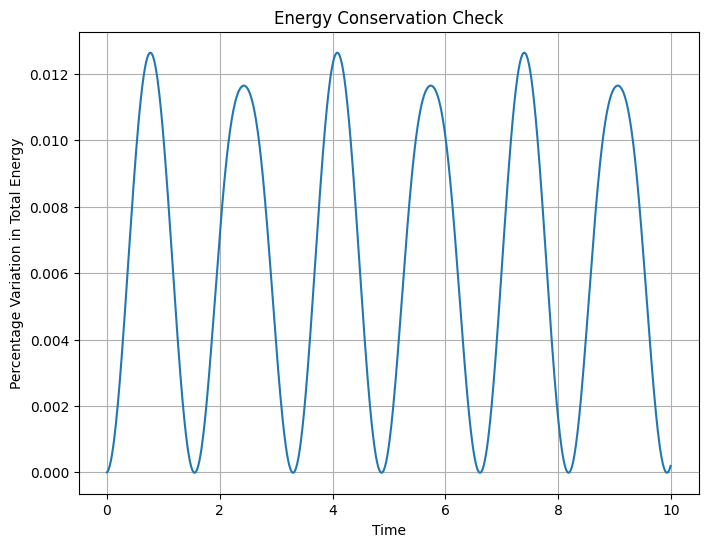

In [11]:
# Plotting the variation in total energy (as a percentage) as a function of time
total_energy = data['Total Energy']

initial_energy = total_energy[0]
percentage_variation = ((total_energy - initial_energy) / initial_energy) * 100

plt.figure(figsize=(8, 6))
plt.plot(time, percentage_variation)
plt.xlabel("Time")
plt.ylabel("Percentage Variation in Total Energy")
plt.title("Energy Conservation Check")
plt.grid(True)
plt.show()

In [12]:
# Now calculating the mean value of the position
mean_position = positions.mean()
print("Mean Position: {:.5f}".format(mean_position))

Mean Position: -0.05155


## OPTIONNAL :Beyond the potential of one dimension - 2D potentials

<div class="rqT" title="Directives">
    
- A two-dimensional potential can simply be created by adding a one-dimensional potential along x and another along y, as well as any coupling function between x and y.
    
 $$ V(x,y)=V_1(x)+V_2(y)+f(x,y) $$
    
where $𝑉_1 (𝑥)$ and $𝑉_2 (𝑦)$ can be one of the previous potential and with, for example, $𝑓(𝑥,𝑦)=𝑥.𝑦$
    
Using a double-well potential for $𝑉_1 (𝑥)$ and $𝑉_2 (𝑦)$ and the coupling function define just before will creat a four-well potential.


- Another way to implement a two-dimensional potential is to use the so-called Muller-Brown potential:
   $$ V(x,y)=\sum_{i=1}^4 A_i.exp[a_i(x-x^0_i)^2+b_i(x-x^0_i)(y-y^0_i)+c_i(y-y^0_i)^2] $$
    
with

A = (−200, −100, −170, 15)
    
a = (−1, −1, −6.5, 0.7) ; b = (0, 0, 11, 0.6) ; c = (−10, −10, −6.5, 0.7)
    
$x^0$ = (1, 0, −0.5, −1) ; $y^0$ = (0, 0.5, 1.5, 1)
     
</div>

<div class="rqT" title="Directives">
    
- For the Velocity-Verlet algorithm, you will need to calculate new positions (new $x$ and new $y$) and speeds (new $v_x$ and new $v_y$) using the formula given at the beginning:

For $x$:
    
\begin{align}    
\mathbf{x(t+\delta t)=x(t)+v_x(t).\delta t-\frac{1}{2M}\frac{\partial V(x(t),y(t))}{\partial x}.\delta t^2} \\    
\end{align}
    
\begin{align}   
\mathbf{v_x(t+\delta t)=v_x(t)-\frac{1}{2M}[\frac{\partial V(x(t),y(t))}{\partial x}+\frac{\partial V(x(t+\delta t),y(t+\delta t))}{\partial x}].\delta t} \\
\end{align}
    
For $y$:
    
\begin{align}    
\mathbf{y(t+\delta t)=y(t)+v_y(t).\delta t-\frac{1}{2M}\frac{\partial V(x(t),y(t))}{\partial y}.\delta t^2} \\    
\end{align}
    
\begin{align}   
\mathbf{v_y(t+\delta t)=v_y(t)-\frac{1}{2M}[\frac{\partial V(x(t),y(t))}{\partial y}+\frac{\partial V(x(t+\delta t),y(t+\delta t))}{\partial y}].\delta t} \\
\end{align}
        
</div>

<div class="exE">

- You need to answer the same questions as for the 1D potential problem
    
    
</div>

## Definition of the differents potentials in 2D

In [13]:
# Define the symbolic variables for x and y
x, y = sym.symbols('x y')

# Define parameters for the Muller-Brown potential
A = [-200, -100, -170, 15]
a = [-1, -1, -6.5, 0.7]
b = [0, 0, 11, 0.6]
c = [-10, -10, -6.5, 0.7]
x0 = [1, 0, -0.5, -1]
y0 = [0, 0.5, 1.5, 1]

# Define functions for the two-dimensional potential
def four_well_potential(x, y):
    # Define one-dimensional potentials V1(x) and V2(y)
    V1 = double_well_potential(x)
    V2 = double_well_potential(y)
    
    # Define the coupling function f(x, y)
    f = x * y
    
    # Combine V1(x), V2(y), and f(x, y) to create the two-dimensional potential
    potential_2d = V1 + V2 + f
    
    return potential_2d

def muller_brown_potential(x, y):
    potential_2d = 0
    for i in range(4):
        potential_2d += A[i] * sym.exp(a[i] * (x - x0[i])**2 + b[i] * (x - x0[i]) * (y - y0[i]) + c[i] * (y - y0[i])**2)
    
    return potential_2d


# Define the force functions (negative gradient of potential energy)
def four_well_force(x, y):
    force_x = -sym.diff(four_well_potential(x, y), x)
    force_y = -sym.diff(four_well_potential(x, y), y)
    return force_x, force_y

def muller_brown_force(x, y):
    force_x = -sym.diff(muller_brown_potential(x, y), x)
    force_y = -sym.diff(muller_brown_potential(x, y), y)
    return force_x, force_y

# function for displaying the analytic expression of the selected potential and associated forces
def display(potential, force):
    print("Display analytic expression of the selected potential:\n")
    sym.pprint(potential(x, y), use_unicode=True)
    print("\n\nDisplay analytic expression of the associated forces:\n")
    sym.pprint(force(x, y), use_unicode=True)

In [14]:
# The selected potential is double-well potential
selected_potential = muller_brown_potential

selected_force = muller_brown_force

display(selected_potential, selected_force)

Display analytic expression of the selected potential:

          2               2              2          2                         
       - x  - 10⋅(y - 0.5)         - 10⋅y  - (x - 1)        (0.6⋅x + 0.6)⋅(y -
- 100⋅ℯ                     - 200⋅ℯ                   + 15⋅ℯ                  

                 2              2                       2                     
 1) + 0.7⋅(x + 1)  + 0.7⋅(y - 1)         - 6.5⋅(x + 0.5)  + (11⋅x + 5.5)⋅(y - 
                                  - 170⋅ℯ                                     

                                       2
1.5) - 14.625⋅(0.666666666666667⋅y - 1) 
                                        


Display analytic expression of the associated forces:

⎛            2               2                        2          2            
⎜         - x  - 10⋅(y - 0.5)                   - 10⋅y  - (x - 1)             
⎝- 200⋅x⋅ℯ                     + 200⋅(2 - 2⋅x)⋅ℯ                   + 170⋅(-13.

                                   2              

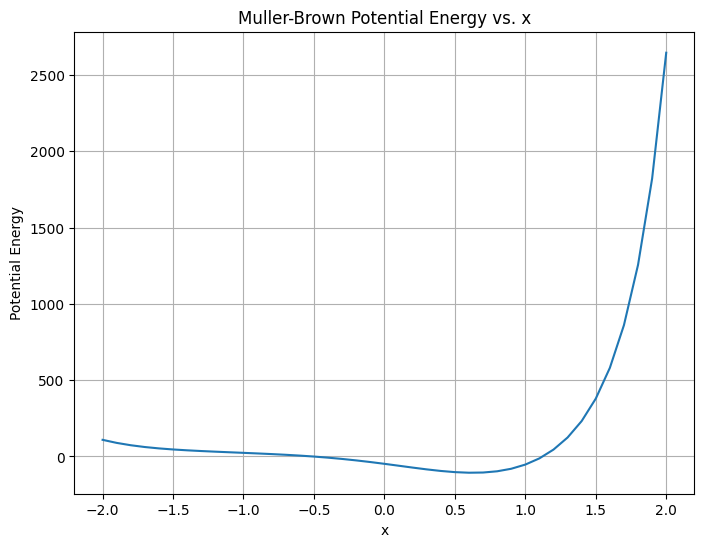

In [15]:
# Lambdify the selected potential for numerical calculations
potential_numeric = sym.lambdify((x, y), selected_potential(x, y), 'numpy')

# Lambdify the selected force for numerical calculations
force_numeric = sym.lambdify((x, y), selected_force(x, y), 'numpy')

# Define the range of x values for plotting
x_values = [i / 10 for i in range(-20, 21)]

# Calculate potential values for the selected potential
potential_values = [potential_numeric(val, 0) for val in x_values]

# Plot the selected potential as a function of the variable 'x'
plt.figure(figsize=(8, 6))
plt.plot(x_values, potential_values)
plt.xlabel("x")
plt.ylabel("Potential Energy")
plt.title("Muller-Brown Potential Energy vs. x")
plt.grid(True)
plt.show()

## Velocity Verlet Algorithm in 2D

In [16]:
# Define symbolic variables
x, y = sym.symbols('x y')

# Define parameters for the Muller-Brown potential
A = [-200, -100, -170, 15]
a = [-1, -1, -6.5, 0.7]
b = [0, 0, 11, 0.6]
c = [-10, -10, -6.5, 0.7]
x0 = [1, 0, -0.5, -1]
y0 = [0, 0.5, 1.5, 1]

# Define functions for the two-dimensional potential
def muller_brown_potential(x, y):
    potential_2d = 0
    for i in range(4):
        term = A[i] * sym.exp(a[i] * (x - x0[i])**2 + b[i] * (x - x0[i]) * (y - y0[i]) + c[i] * (y - y0[i])**2)
        term_evaluated = term.evalf()  # Evaluate the term with default precision
        potential_2d += term_evaluated
    return potential_2d

# Define the force functions (negative gradient of potential energy)
def muller_brown_force(x, y):
    force_x = -sym.diff(muller_brown_potential(x, y), x)
    force_y = -sym.diff(muller_brown_potential(x, y), y)
    return force_x, force_y

# Simulation parameters
total_steps = 1000
delta_t = 0.001
mass = 1.0  # Mass of the particle

# Initial conditions
current_x = random.uniform(-1.5, 2.0)
current_y = random.uniform(-0.5, 2.0)
current_vx = random.uniform(-0.1, 0.1)
current_vy = random.uniform(-0.1, 0.1)

# Initialize arrays to record data
time_values = []
position_x_values = []
position_y_values = []
velocity_x_values = []
velocity_y_values = []
potential_energy_values = []
total_energy_values = []

for step in range(total_steps):
    # Append the current values to the arrays
    time_values.append(step * delta_t)
    position_x_values.append(current_x)
    position_y_values.append(current_y)
    velocity_x_values.append(current_vx)
    velocity_y_values.append(current_vy)
    potential_energy_values.append(muller_brown_potential(current_x, current_y))
    total_energy_values.append(potential_energy_values[-1] + 0.5 * mass * (current_vx**2 + current_vy**2))

    # Calculate forces at the current position using finite differences
    delta = 1e-8
    force_x = (muller_brown_potential(current_x + delta, current_y) - muller_brown_potential(current_x, current_y)) / delta
    force_y = (muller_brown_potential(current_x, current_y + delta) - muller_brown_potential(current_x, current_y)) / delta

    # Update positions using Velocity Verlet algorithm
    new_x = current_x + current_vx * delta_t + 0.5 * (force_x / mass) * (delta_t ** 2)
    new_y = current_y + current_vy * delta_t + 0.5 * (force_y / mass) * (delta_t ** 2)

    # Calculate forces at the new positions using finite differences
    force_x_new = (muller_brown_potential(new_x + delta, new_y) - muller_brown_potential(new_x, new_y)) / delta
    force_y_new = (muller_brown_potential(new_x, new_y + delta) - muller_brown_potential(new_x, new_y)) / delta

    # Update velocities using Velocity Verlet algorithm
    new_vx = current_vx + 0.5 * ((force_x / mass) + (force_x_new / mass)) * delta_t
    new_vy = current_vy + 0.5 * ((force_y / mass) + (force_y_new / mass)) * delta_t

    # Update variables for the next iteration
    current_x, current_y, current_vx, current_vy = new_x, new_y, new_vx, new_vy

In [17]:
# Create a DataFrame to store the recorded data
data = {
    'Time': time_values,
    'Position_X': position_x_values,
    'Position_Y': position_y_values,
    'Velocity_X': velocity_x_values,
    'Velocity_Y': velocity_y_values,
    'Potential Energy': potential_energy_values,
    'Total Energy': total_energy_values
}

df = pd.DataFrame(data)

# Save the recorded data to a CSV file
df.to_csv('md_simulation_2d_data.csv', index=False)

print("Data saved to md_simulation_2d_data.csv")


Data saved to md_simulation_2d_data.csv


## Post processing for 2D

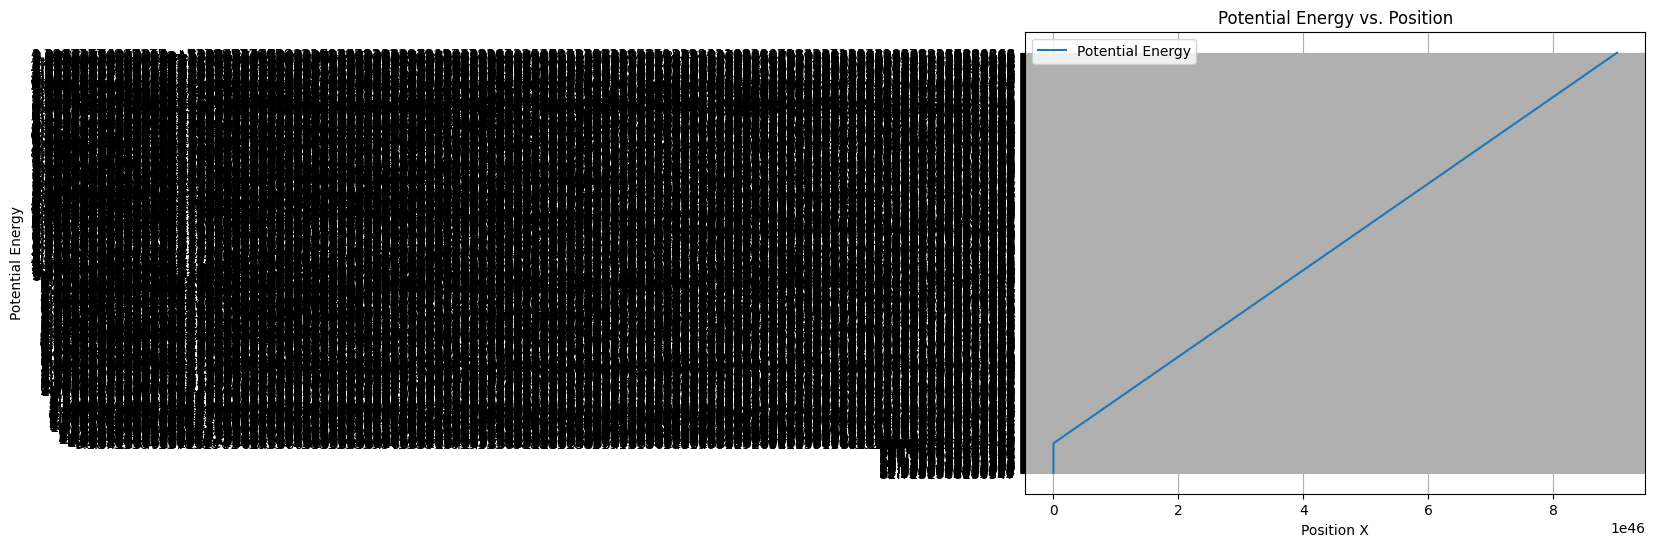

In [18]:
# Plotting Potentials as a Function of Positions:
# Load the data from the CSV file
df = pd.read_csv('md_simulation_2d_data.csv')

# Plot the potential energy as a function of positions
plt.figure(figsize=(8, 6))
plt.plot(df['Position_X'], df['Potential Energy'], label='Potential Energy')
plt.xlabel('Position X')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs. Position')
plt.legend()
plt.grid(True)
plt.show()

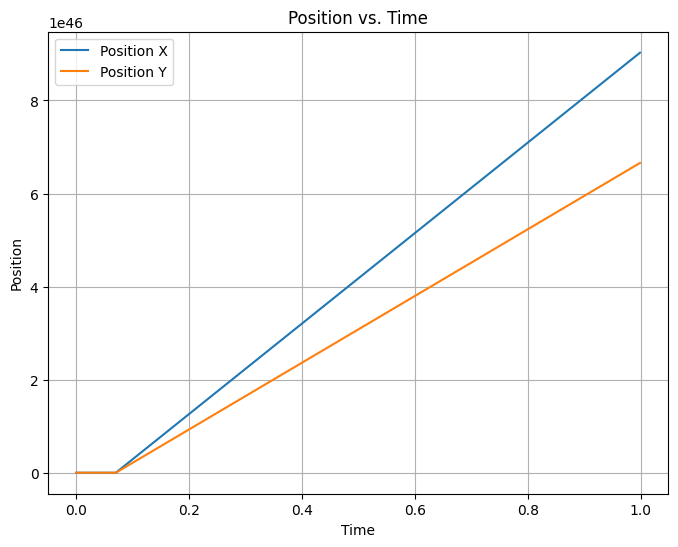

In [19]:
# Plot positions as a function of time
plt.figure(figsize=(8, 6))
plt.plot(df['Time'], df['Position_X'], label='Position X')
plt.plot(df['Time'], df['Position_Y'], label='Position Y')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Position vs. Time')
plt.legend()
plt.grid(True)
plt.show()

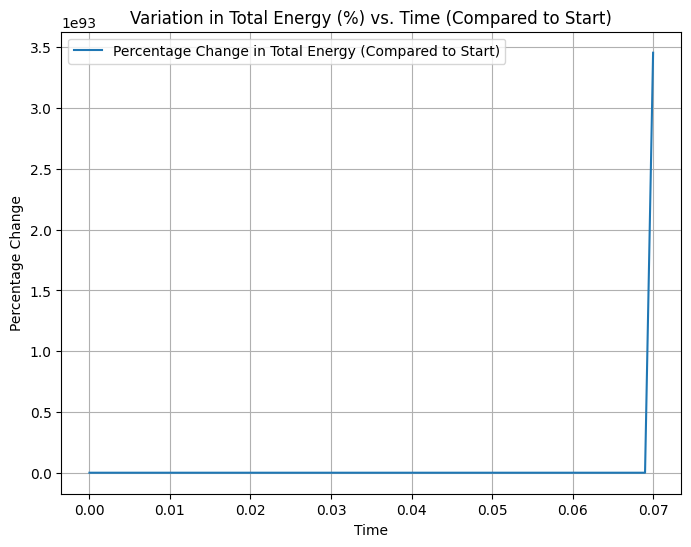

In [20]:
# Calculate percentage change in total energy
df['Total Energy'] = df['Total Energy'].astype(float)
initial_total_energy = float(df['Total Energy'].iloc[0])
df['Percentage Change'] = ((df['Total Energy'] - initial_total_energy) / initial_total_energy) * 100

# Plot the variation in total energy as a percentage compared to the initial value
plt.figure(figsize=(8, 6))
plt.plot(df['Time'], df['Percentage Change'], label='Percentage Change in Total Energy (Compared to Start)')
plt.xlabel('Time')
plt.ylabel('Percentage Change')
plt.title('Variation in Total Energy (%) vs. Time (Compared to Start)')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Calculate the mean position
mean_position_x = df['Position_X'].mean()
mean_position_y = df['Position_Y'].mean()

print(f"Mean Position X: {mean_position_x}")
print(f"Mean Position Y: {mean_position_y}")

Mean Position X: 4.1974438328696806e+46
Mean Position Y: 3.0957100862912307e+46


# End

In [22]:
vID.end(cwd0)

**End at:** Friday 10 November 2023, 10:25:19  
**Duration:** 00:00:35 290ms

<p style="text-align: center"><img width="800px" src="./config/svg/logoEnd.svg" style="margin-left:auto; margin-right:auto"/></p>